# Notebook used to visualize the daily distribution of electrical events, as depicted in the data descriptor

## Load packages and basic dataset information

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

from matplotlib import patches
import h5py
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import math
import seaborn as sns
import pdb
import scipy
# Add project path to path for import
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

# Add module path to path for import
module_path = os.path.abspath("../data_utility/data_utility.py")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_utility import CREAM_Day # class to work with a day of the CREAM Dataset

# Intentional replication is necessary
%load_ext autoreload
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Import some graphical modules
from IPython.display import display, clear_output
from ipywidgets import Button, Layout, ButtonStyle, HBox, VBox, widgets, Output
from IPython.display import SVG, display, clear_output

import subprocess
import glob

In [7]:
PATH_TO_DATA = os.path.abspath(os.path.join("..", "..","rbgstorage", "nilm", "i13-dataset", "CREAM"))

In [8]:
def create_time_bin(hours : float, minutes : float) -> str:
    """
    Creates a hour:minutes timestamp, ceiled to full 30 minutes.
    All minutes below 15, become 0.
    All between 15 and 45 minutes, become 30 minutes.
    All minutes between 45 and 60 become 0 and belong to the next hour.
    """
    if minutes < 15:
        minutes = "00"
    elif minutes >= 15 and minutes < 45:
        minutes = "30"
    elif minutes >= 45:
        minutes = "00"
        hours += 1
    
    if hours < 10:
        hours = "0" + str(hours)
    else:
        hours = str(hours)
    
    return hours + ":" + minutes

def get_distribution(path_to_data, machine_name):
    path_to_data = os.path.join(path_to_data, machine_name)
    all_days = glob.glob(os.path.join(path_to_data, "*"))
    all_days = [os.path.basename(d) for d in all_days if "2018" in os.path.basename(d)  or "2019" in os.path.basename(d)  ]
    all_days.sort()
    
    # Load the events 
    day_path = os.path.join(path_to_data, all_days[0]) #arbitrary day to initialize the object
    current_CREAM_day = CREAM_Day(cream_day_location=day_path,use_buffer=True, buffer_size_files=2) 

    # Load the electrical component events (the raw ones)
    if machine == "X9":
        all_component_events = current_CREAM_day.load_component_events(os.path.join(path_to_data, "component_events_coarse.csv"), filter_day=False)

    else:
        all_component_events = current_CREAM_day.load_component_events(os.path.join(path_to_data, "component_events.csv"), filter_day=False)

    # Load the product and the maintenance events (the raw ones, per minute events) and filter for the day
    all_maintenance_events = current_CREAM_day.load_machine_events(os.path.join(path_to_data, "maintenance_events.csv"), raw_file=False, filter_day=False)
    all_product_events = current_CREAM_day.load_machine_events(os.path.join(path_to_data, "product_events.csv"), raw_file=False, filter_day=False)
    
    # create a new column with: hour:30, hour:0 in it for the x-axis as the labels
    all_component_events["Time_Bin"] = all_component_events.Timestamp.apply(lambda x: create_time_bin(x.hour, x.minute))

    times, counts = np.unique(all_component_events["Time_Bin"] , return_counts=True)

    return times, counts
    

# Plot of the daily distribution of electrical events

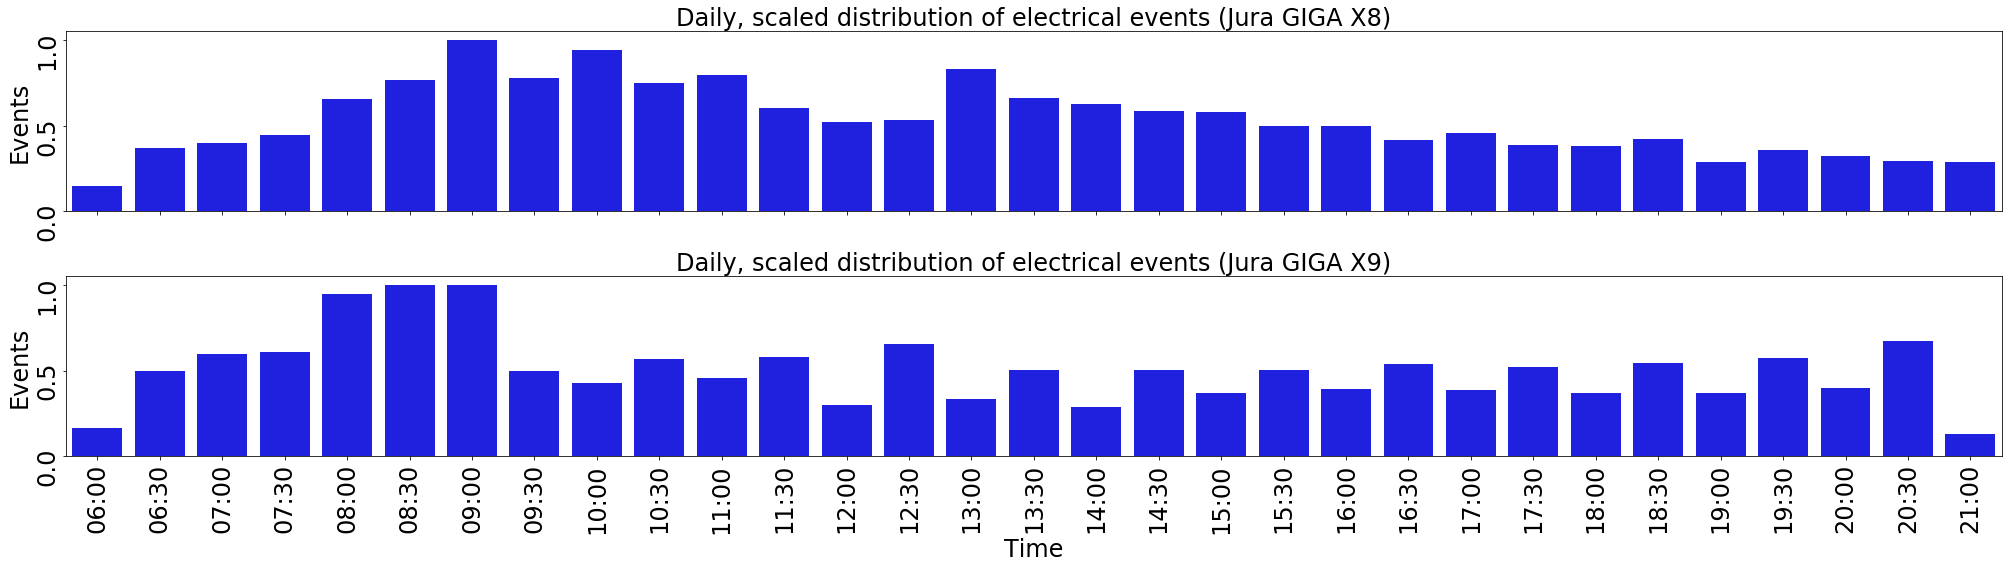

In [16]:
# Create the figure
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(28,8))

# Iterate over the machines
for i, machine in enumerate(["X8", "X9"]):
    
    # get the axis object
    ax = axes[i]
    
    # get the count information for the barplot
    times, counts = get_distribution(path_to_data=PATH_TO_DATA,
                                      machine_name=machine)
    # scale the counts between 0 and 1
    counts = counts / np.max(counts)
    
    title_text = "Daily, scaled distribution of electrical events (Jura GIGA " + machine + ")"
    ax.set_title(label = title_text, fontdict={'fontsize': 24})
    ax.set_ylabel("Events", fontsize=24)
    ax.tick_params(axis="both", labelsize=24, rotation=90)
    # ax.set_ylim(0, 20000)
    sns.barplot(x=times, y=counts,color="b", ax=ax)
    
plt.xlabel("Time", fontsize=24)
    
plt.tight_layout()
plt.savefig("./Figure_3_BOTH.pdf")
plt.show()